# Disease Prediction & Smart Health Advisory System — Project Blueprint (Notebook Overview)
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade

> **Purpose:** Build a clinically responsible, end-to-end system that learns from symptom data to predict likely diseases (**multi-class classification**) and powers a **Smart Health Advisory** that suggests next steps (self-care guidance, tests to consider, and flags for urgent care). This notebook is a complete, reproducible path from problem framing to deployment and monitoring.

---

## 1) Problem Framing & Scope

- **Primary task:** Predict `prognosis` from symptom features (binary/indicator columns such as `itching`, `skin_rash`, …).
- **Secondary task:** Provide **actionable, explainable** advice (triage hints, suggested investigations), derived from model outputs + rules.
- **Constraints & responsibilities:**
  - Privacy by design; no PII is expected, but we treat data as sensitive.
  - Model explanations are mandatory for every prediction.
  - This tool **does not provide medical diagnosis**; it is a decision-support/education aid. Clinician review is recommended for critical cases.

---

## 2) Data Overview

- **Inputs:** Training and testing sets with symptom indicators (0/1 or categorical), plus `prognosis` (target) in train.
- **Features:** Symptoms such as `high_fever`, `yellowing_of_eyes`, `abdominal_pain`, etc. (see dataset list).
- **Target:** `prognosis` (multi-class; each class is a disease/condition).
- **Assumptions:** Features are primarily binary; class distribution may be imbalanced.

---

## 3) End-to-End Pipeline (What We Will Build)

1. **Environment & Reproducibility**
   - Fixed random seeds, dependency pinning, and config file.
2. **Data Intake & Governance**
   - Schema validation (types/ranges), missingness audit, duplicate checks.
3. **EDA (Exploratory Data Analysis)**
   - Class prevalence, symptom frequency, co-occurrence, correlation/association maps.
   - Leakage checks and stability across train/test.
4. **Preprocessing**
   - Imputation (if needed), consistent encoding, optional scaling (for distance-based models), train/validation/test splits (stratified).
5. **Baseline Models**
   - Simple tree and logistic baselines for reference; establish a performance floor.
6. **Modeling (Primary)**
   - Tree-based ensembles (e.g., Random Forest, Gradient Boosting).
   - Class-imbalance strategies: class weights / calibrated sampling.
   - Hyperparameter optimization via cross-validation.
7. **Evaluation**
   - Macro/micro **F1**, per-class precision/recall, confusion matrices, top-k accuracy.
   - **Calibration** (reliability curves, Brier score) to make probabilities trustworthy.
8. **Explainability**
   - Global feature importance.
   - **Per-prediction** explanations with SHAP values.
   - Human-readable rationales for each returned prediction.
9. **Risk Controls & Safety**
   - Thresholding + top-k differential outputs.
   - Guardrails: when confidence is low or red-flag features appear, elevate triage level.
10. **Smart Health Advisory**
    - Rules + model outputs to suggest next steps (e.g., “consider lab test X”, “seek urgent care if Y”).
11. **Packaging & Deployment**
    - Export model (e.g., `joblib`/ONNX), versioned artifacts, **FastAPI** REST service.
    - Input validation (Pydantic), consistent preprocessing with a single pipeline object.
12. **Monitoring & MLOps**
    - Data drift & concept drift checks, performance tracking, feedback loop, periodic retraining triggers.
13. **Documentation**
    - Model card (intended use, limitations), datasheet, change log, and test coverage.

---

## 4) Metrics & Validation Strategy

- **Primary:** Macro-F1 (balances performance across classes), per-class F1.
- **Secondary:** Accuracy, macro-precision/recall, top-k accuracy, calibration metrics.
- **Validation:** Stratified k-fold CV on train; test set held out strictly once modeling is finalized.
- **Error Analysis:** Per-class confusion matrices, hardest confusions, symptom pattern review.

---

## 5) Explainability & Transparency

- **Global view:** Which symptoms generally drive predictions for each disease.
- **Local view:** For each user case, show the top contributing symptoms (SHAP-based) with plain-language explanations.
- **Auditability:** Deterministic pipeline; versioned data schema and model artifacts.

---

## 6) Risk, Ethics, and Compliance Notes

- **Not a diagnostic device.** For information and decision support only.
- Bias & fairness checks (per-class performance parity as a proxy given symptom-only inputs).
- Clear disclaimers and escalation rules for high-risk signals (e.g., severe/acute symptom clusters).

---

## 7) Deliverables

- Reproducible notebook and modular Python package:
  - `pipeline.pkl` (preprocess + model), `explainer.bin`, config, and API.
- **FastAPI** microservice with `/predict` and `/explain` endpoints.
- Model Card + Datasheet, evaluation report, monitoring dashboard template.

---

## 8) Notebook Roadmap (Sections & Cells)

1. **Setup & Configuration**
2. **Load Data & Schema Validation**
3. **EDA: Class Distribution & Symptom Insights**
4. **Preprocessing & Split (Stratified)**
5. **Baselines & Sanity Checks**
6. **Model Training with CV & HPO**
7. **Calibration & Final Evaluation on Test**
8. **Explainability: Global & Local (SHAP)**
9. **Smart Health Advisory Layer (Rules + Model)**
10. **Packaging: Export Pipeline & Explainer**
11. **API Prototype with FastAPI**
12. **Monitoring: Drift & Performance Templates**
13. **Model Card & Documentation Snapshot**

---

## 9) Usage Modes (Post-Deployment)

- **Clinician/Analyst:** Batch scoring with explanations and reports.
- **End-User:** Symptom entry → top-k likely conditions + advisory and safety notices.
- **Ops:** Monitoring, alerts on drift, feedback capture for active learning.

---

## 10) Limitations & Next Steps

- Generalization depends on source data coverage and label quality.
- Continuous improvement via feedback, periodic retraining, and expanded symptom sets/labs where available.

---

**Next Cell:** Environment setup (dependencies, config, and reproducibility seeds).


In [1]:
# 1. Environment Setup & Config

# Standard Libraries
import os
import random
import warnings

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Reproducibility: Set Seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Configure plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

print(" Environment setup complete. Ready to load data.")


 Environment setup complete. Ready to load data.


In [2]:
# 2. Load & Inspect Data

# Paths (adjust if needed)
TRAIN_PATH = "Training.csv"
TEST_PATH  = "Testing.csv"

# Load datasets
train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

# Basic shape
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

# Preview first few rows
display(train_df.head())

# Info about columns & datatypes
print("\n--- Train Info ---")
print(train_df.info())

# Check for missing values
print("\n--- Missing Values (Train) ---")
print(train_df.isnull().sum().sum())

print("\n--- Missing Values (Test) ---")
print(test_df.isnull().sum().sum())

# Target column distribution
print("\n--- Target Distribution (Train) ---")
print(train_df['prognosis'].value_counts(normalize=True) * 100)


Train shape: (4920, 134)
Test shape : (42, 133)


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN



--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 134 entries, itching to Unnamed: 133
dtypes: float64(1), int64(132), object(1)
memory usage: 5.0+ MB
None

--- Missing Values (Train) ---
4920

--- Missing Values (Test) ---
0

--- Target Distribution (Train) ---
prognosis
Fungal infection                           2.439024
Allergy                                    2.439024
GERD                                       2.439024
Chronic cholestasis                        2.439024
Drug Reaction                              2.439024
Peptic ulcer diseae                        2.439024
AIDS                                       2.439024
Diabetes                                   2.439024
Gastroenteritis                            2.439024
Bronchial Asthma                           2.439024
Hypertension                               2.439024
Migraine                                   2.439024
Cervical spondylosis                       2.43902

In [3]:
# 3. Data Cleaning & Preprocessing

# Drop the useless unnamed column (all NaN)
if "Unnamed: 133" in train_df.columns:
    train_df.drop(columns=["Unnamed: 133"], inplace=True)
if "Unnamed: 133" in test_df.columns:
    test_df.drop(columns=["Unnamed: 133"], inplace=True)

# Encode target labels (prognosis)
label_encoder = LabelEncoder()
train_df['prognosis_encoded'] = label_encoder.fit_transform(train_df['prognosis'])

# Verify encoding
print("Number of unique diseases:", train_df['prognosis'].nunique())
print("Sample class mapping:", dict(zip(label_encoder.classes_[:10], range(10))))

# Separate features and target
X = train_df.drop(columns=['prognosis', 'prognosis_encoded'])
y = train_df['prognosis_encoded']

# Double-check feature/target shapes
print("\nFeature matrix shape:", X.shape)
print("Target vector shape  :", y.shape)

# Test set preview (should align feature-wise with X)
print("\nTest set shape:", test_df.shape)


Number of unique diseases: 41
Sample class mapping: {'(vertigo) Paroymsal  Positional Vertigo': 0, 'AIDS': 1, 'Acne': 2, 'Alcoholic hepatitis': 3, 'Allergy': 4, 'Arthritis': 5, 'Bronchial Asthma': 6, 'Cervical spondylosis': 7, 'Chicken pox': 8, 'Chronic cholestasis': 9}

Feature matrix shape: (4920, 132)
Target vector shape  : (4920,)

Test set shape: (42, 133)


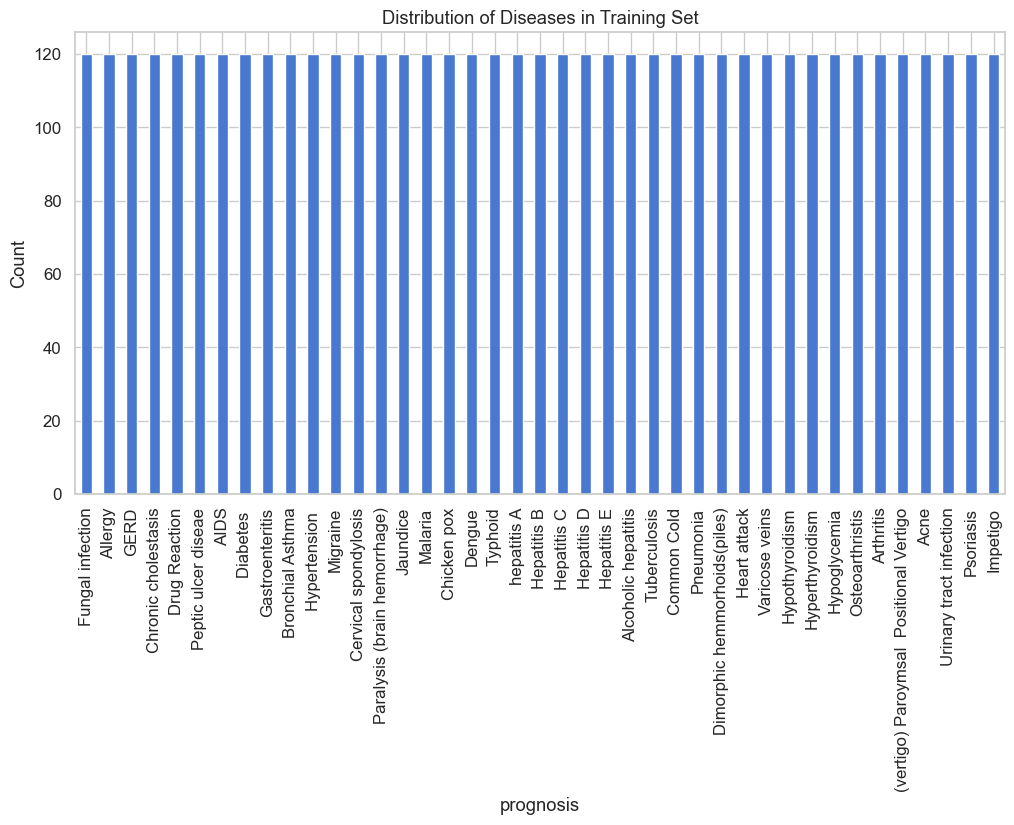

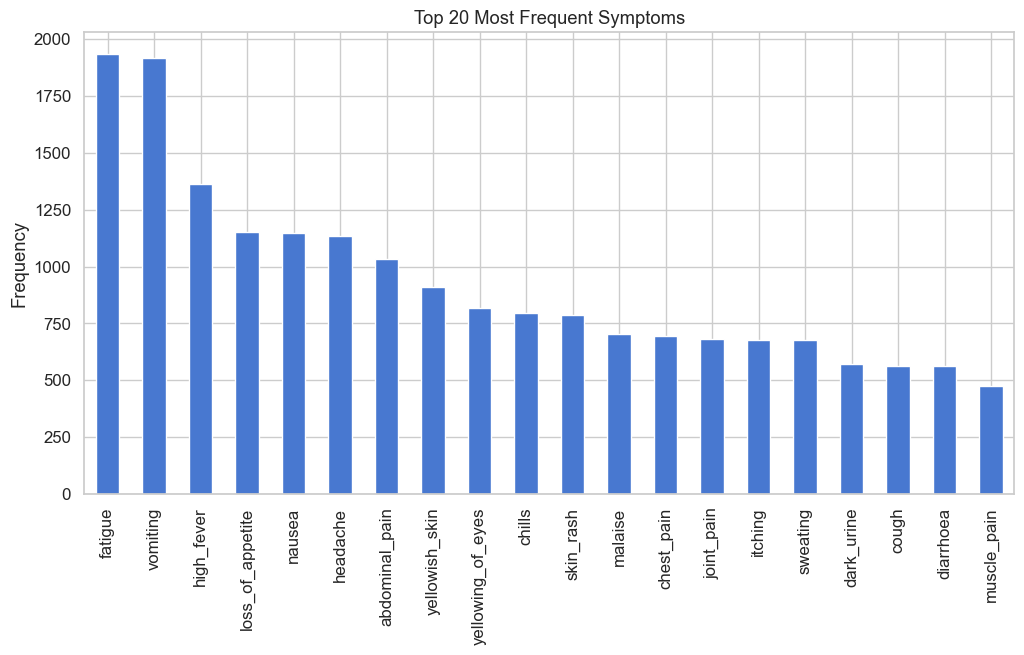

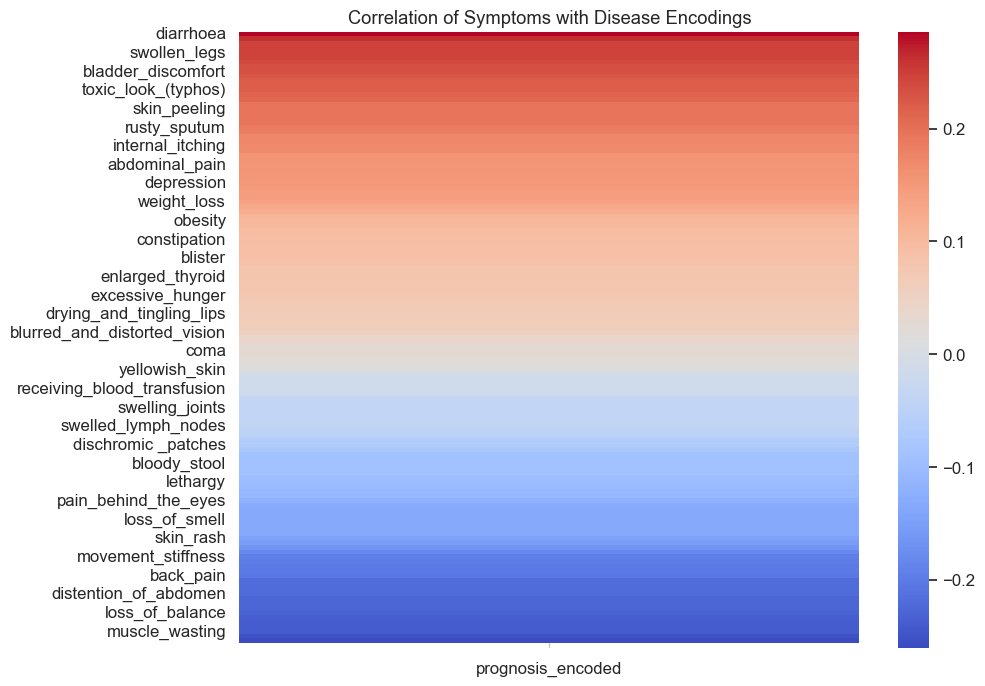

Top 10 symptoms correlated with disease encodings:

diarrhoea                  0.285993
sweating                   0.261934
unsteadiness               0.260331
spinning_movements         0.253230
bruising                   0.247315
prominent_veins_on_calf    0.247315
swollen_legs               0.247315
cramps                     0.247315
muscle_wasting             0.240568
extra_marital_contacts     0.240568
Name: prognosis_encoded, dtype: float64


In [4]:
# 4. Exploratory Data Analysis

# 1. Target Distribution (Balanced check)
plt.figure(figsize=(12,6))
train_df['prognosis'].value_counts().plot(kind='bar')
plt.title("Distribution of Diseases in Training Set")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

# 2. Symptom prevalence across dataset
symptom_freq = X.sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
symptom_freq.head(20).plot(kind='bar')
plt.title("Top 20 Most Frequent Symptoms")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

# 3. Correlation heatmap (symptoms vs target)
corr_matrix = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix.iloc[:-1, -1:].sort_values(by='prognosis_encoded', ascending=False), 
            cmap="coolwarm", annot=False)
plt.title("Correlation of Symptoms with Disease Encodings")
plt.show()

# Quick check: which symptoms are most strongly linked to prognosis
symptom_corr = corr_matrix['prognosis_encoded'].drop('prognosis_encoded').abs().sort_values(ascending=False)
print("Top 10 symptoms correlated with disease encodings:\n")
print(symptom_corr.head(10))


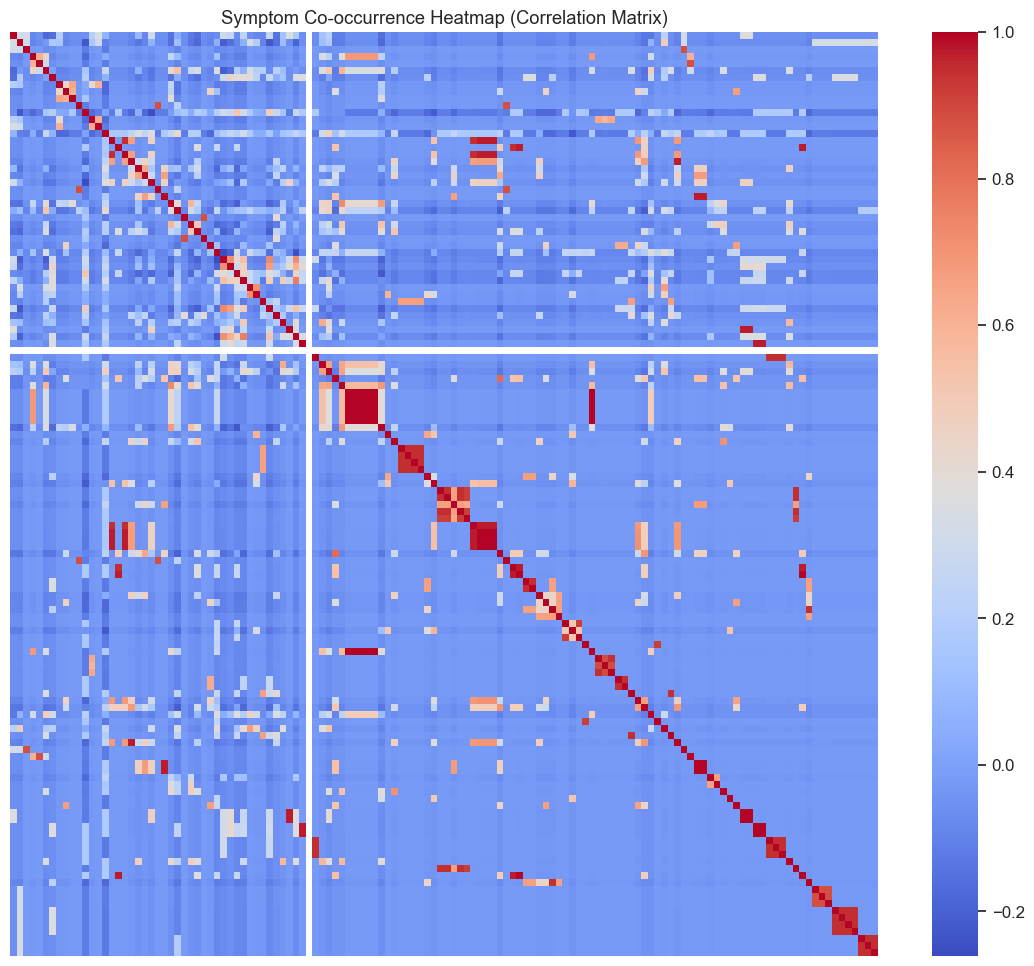

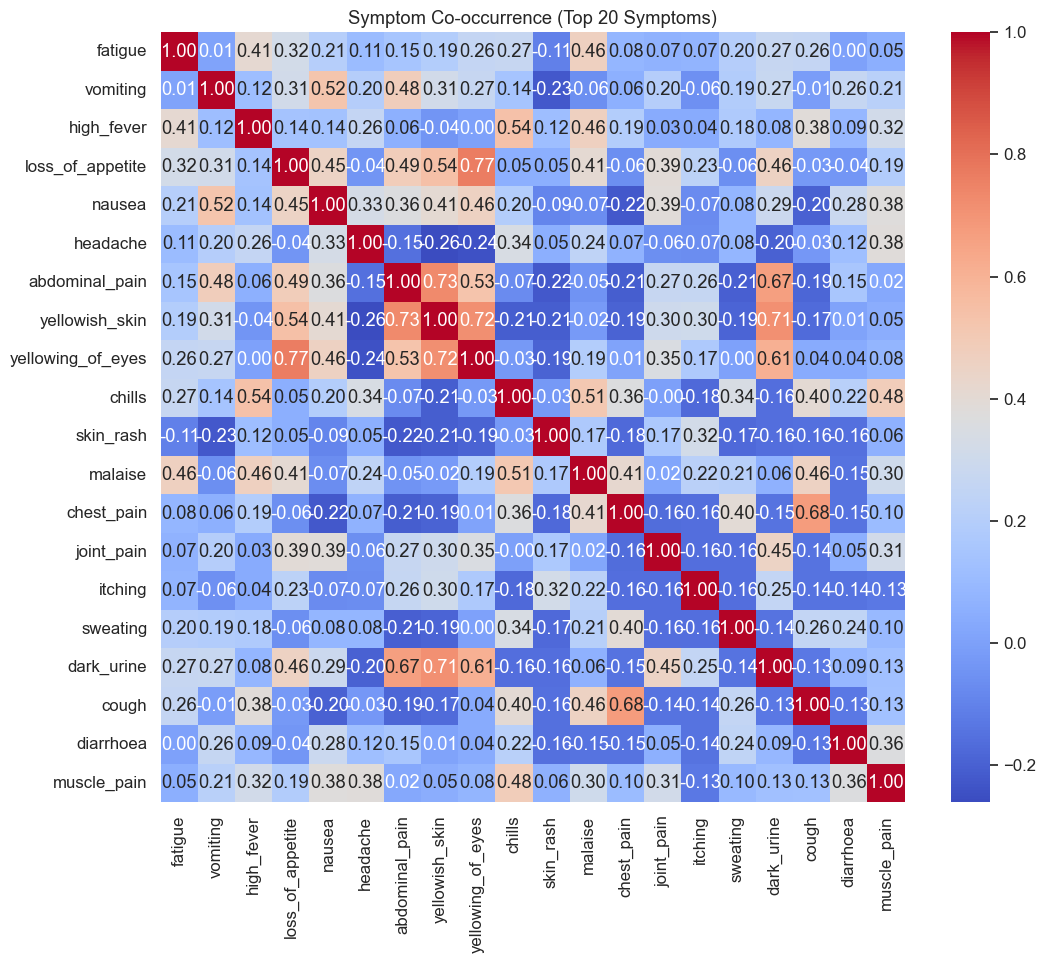

In [5]:
# 4b. Symptom Co-occurrence Heatmap

# Compute co-occurrence (symptom-symptom correlation)
symptom_corr = X.corr()

# Plot heatmap (sample subset for readability)
plt.figure(figsize=(14,12))
sns.heatmap(symptom_corr, cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=False)
plt.title("Symptom Co-occurrence Heatmap (Correlation Matrix)")
plt.show()

# Optional: Focus on top 20 most frequent symptoms for clarity
top_symptoms = symptom_freq.head(20).index
plt.figure(figsize=(12,10))
sns.heatmap(X[top_symptoms].corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Symptom Co-occurrence (Top 20 Symptoms)")
plt.show()


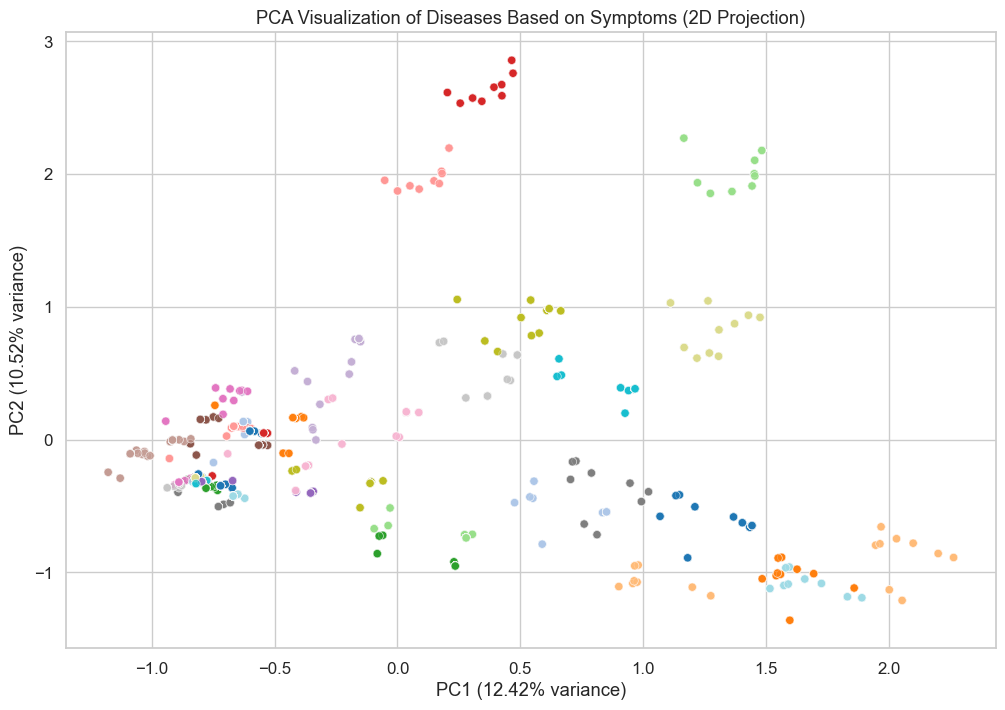

Explained variance ratio (first 2 PCs): [0.12421203 0.10519501]
Cumulative variance explained (2 PCs): 0.2294070367673205


In [6]:
# 4c. PCA Visualization of Disease Separation

from sklearn.decomposition import PCA

# Reduce symptom space (132 features) to 2D
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['prognosis'] = train_df['prognosis']

# Plot PCA scatter
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=pca_df, 
    x="PC1", y="PC2", 
    hue="prognosis", 
    palette="tab20", 
    legend=False,  # Too many classes for full legend
    alpha=0.7
)
plt.title("PCA Visualization of Diseases Based on Symptoms (2D Projection)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
plt.show()

# Variance explained
print("Explained variance ratio (first 2 PCs):", pca.explained_variance_ratio_)
print("Cumulative variance explained (2 PCs):", np.sum(pca.explained_variance_ratio_))


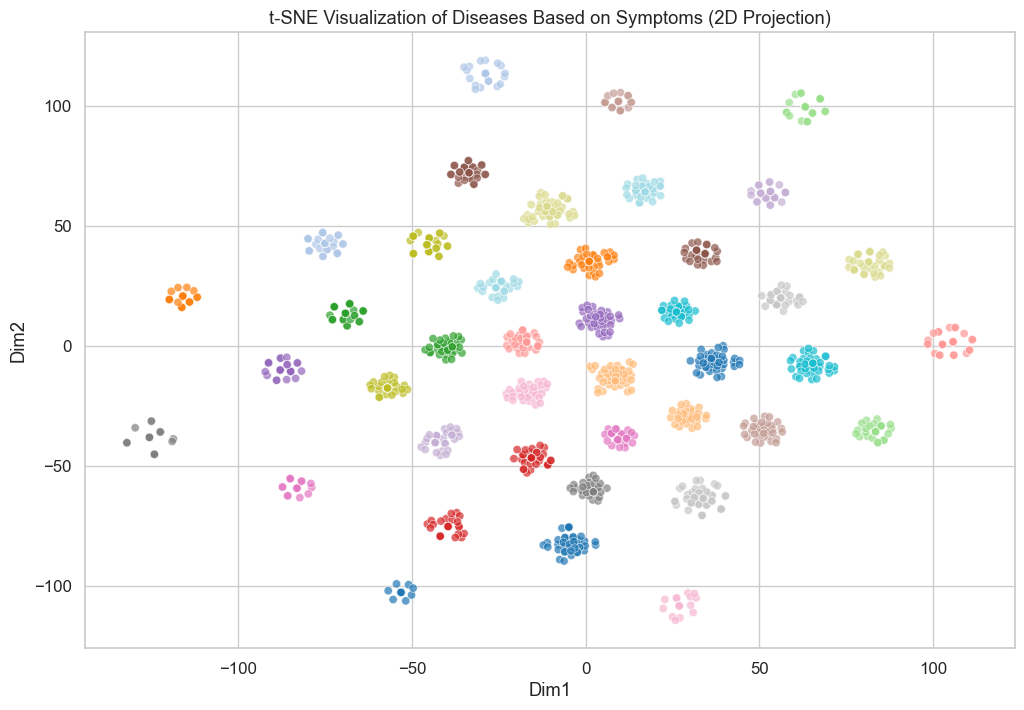

In [7]:
# 4d. t-SNE Visualization of Diseases (2D Mapping)

from sklearn.manifold import TSNE

# Run t-SNE on a sample (full dataset may be slow)
SAMPLE_SIZE = 1500  # adjust if resources allow
X_sample = X.sample(SAMPLE_SIZE, random_state=SEED)
y_sample = y.loc[X_sample.index]
labels_sample = train_df.loc[X_sample.index, "prognosis"]

# Fit t-SNE (2D)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=SEED, max_iter=1000)
X_tsne = tsne.fit_transform(X_sample)

# Create DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
tsne_df["prognosis"] = labels_sample.values

# Plot t-SNE
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=tsne_df,
    x="Dim1", y="Dim2",
    hue="prognosis",
    palette="tab20",
    legend=False,  # hide legend due to 41 classes
    alpha=0.7
)
plt.title("t-SNE Visualization of Diseases Based on Symptoms (2D Projection)")
plt.show()


In [8]:
# 5. Train/Validation Split (Stratified)
from sklearn.model_selection import train_test_split

# Stratified split (preserve class distribution)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print("Training set shape :", X_train.shape, " Target:", y_train.shape)
print("Validation set shape:", X_val.shape, " Target:", y_val.shape)

# Quick check: class balance in train/val
print("\nClass distribution in Training set:")
print(pd.Series(y_train).value_counts(normalize=True).head())

print("\nClass distribution in Validation set:")
print(pd.Series(y_val).value_counts(normalize=True).head())


Training set shape : (3936, 132)  Target: (3936,)
Validation set shape: (984, 132)  Target: (984,)

Class distribution in Training set:
prognosis_encoded
7     0.02439
19    0.02439
28    0.02439
8     0.02439
31    0.02439
Name: proportion, dtype: float64

Class distribution in Validation set:
prognosis_encoded
23    0.02439
14    0.02439
13    0.02439
24    0.02439
31    0.02439
Name: proportion, dtype: float64


In [9]:
# 6. Baseline Model: Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train baseline decision tree
dt_model = DecisionTreeClassifier(random_state=SEED)
dt_model.fit(X_train, y_train)

# Predictions
y_val_pred = dt_model.predict(X_val)

# Evaluation
acc = accuracy_score(y_val, y_val_pred)
print("Baseline Decision Tree Accuracy on Validation Set:", round(acc, 4))

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

# Confusion matrix (compact view)
cm = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix Shape:", cm.shape)


Baseline Decision Tree Accuracy on Validation Set: 1.0

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            C

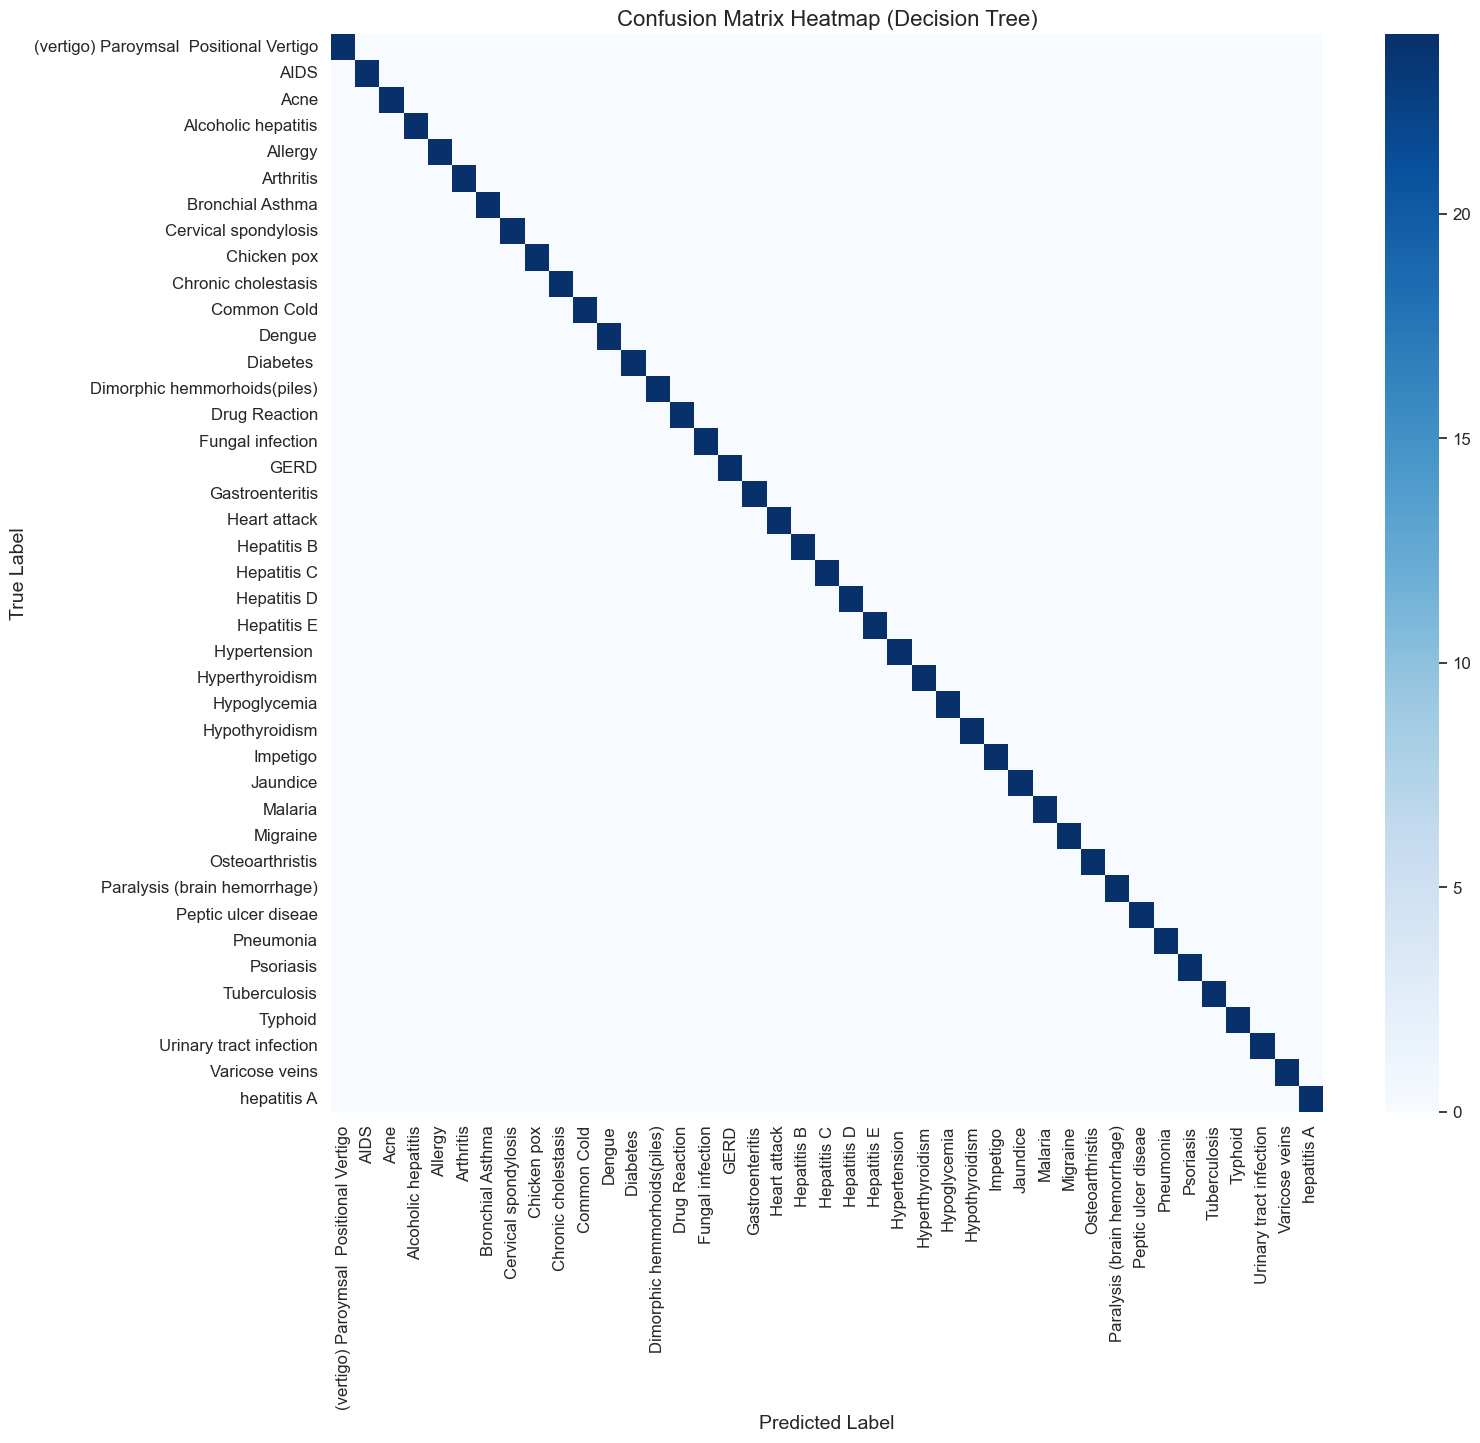

In [10]:
# 7. Confusion Matrix Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, cmap="Blues", 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix Heatmap (Decision Tree)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()


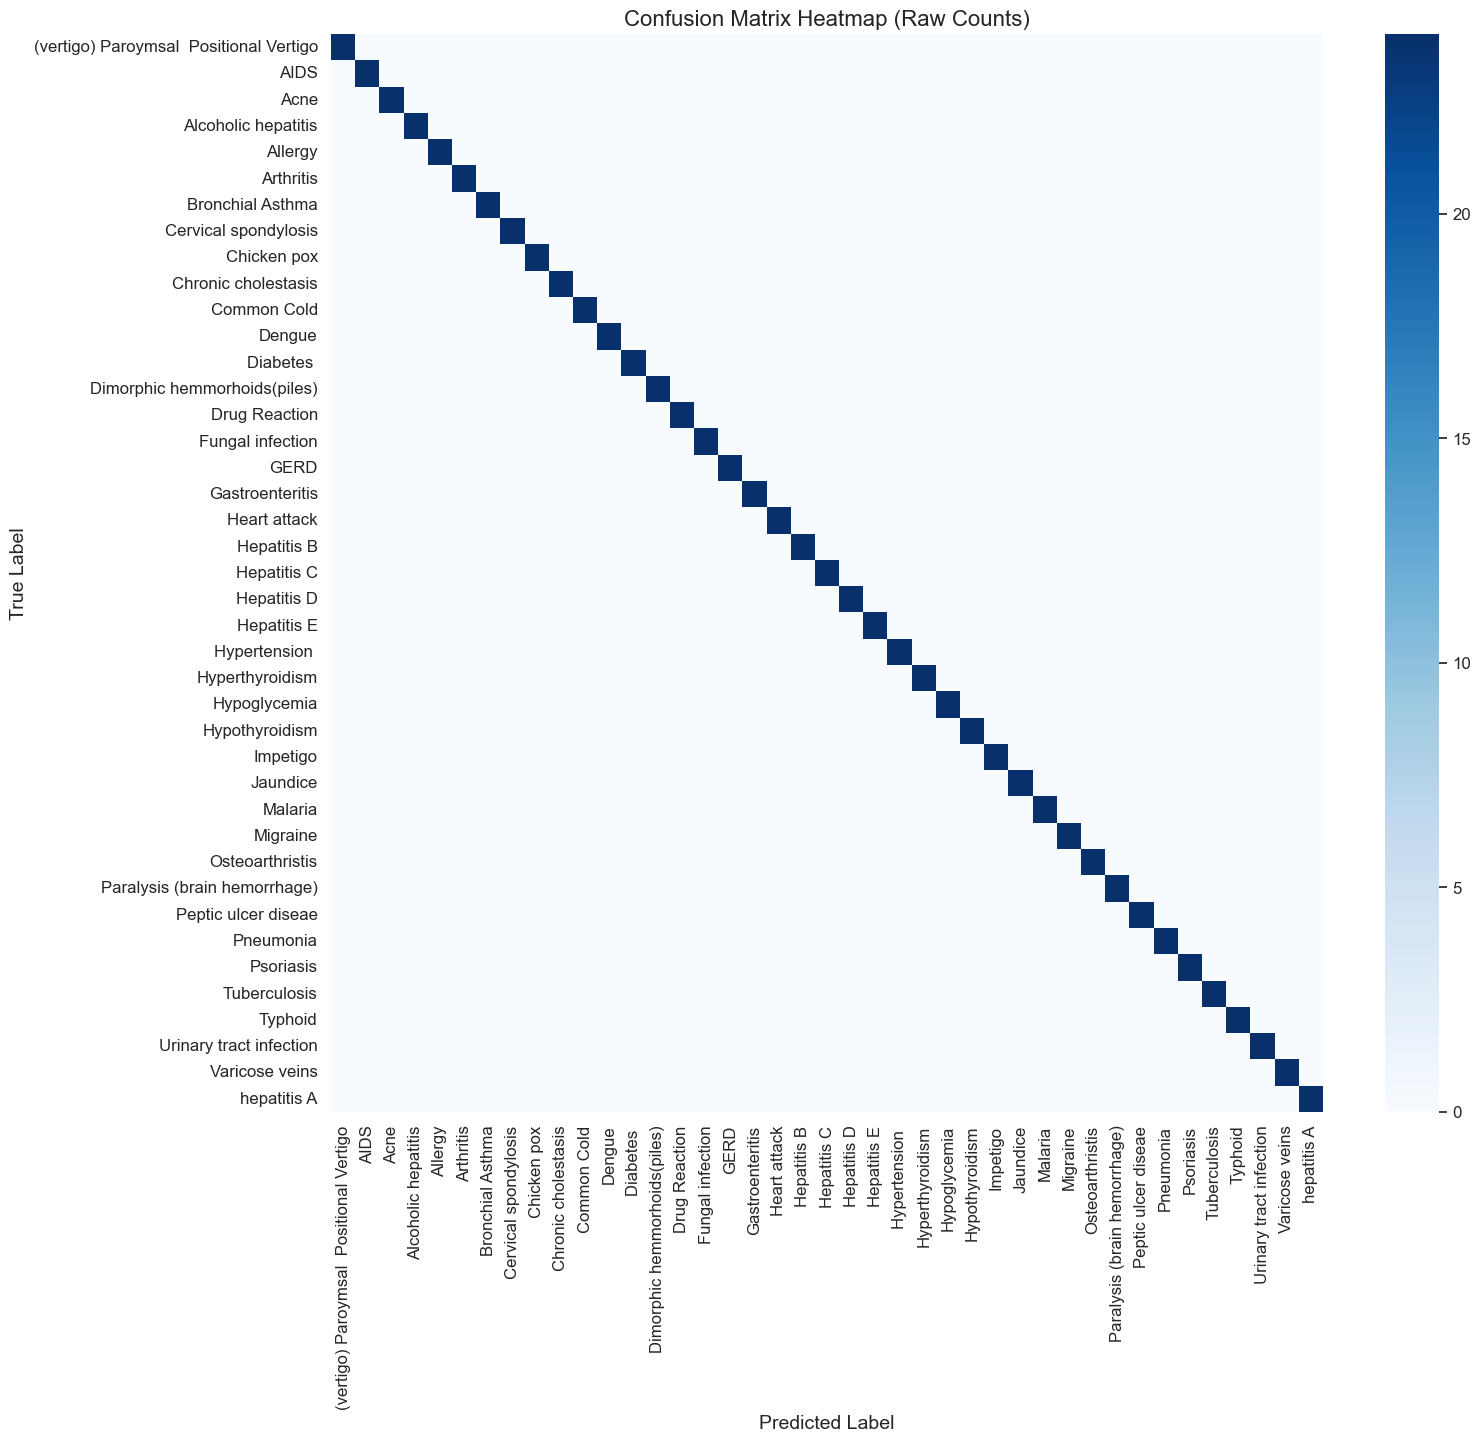

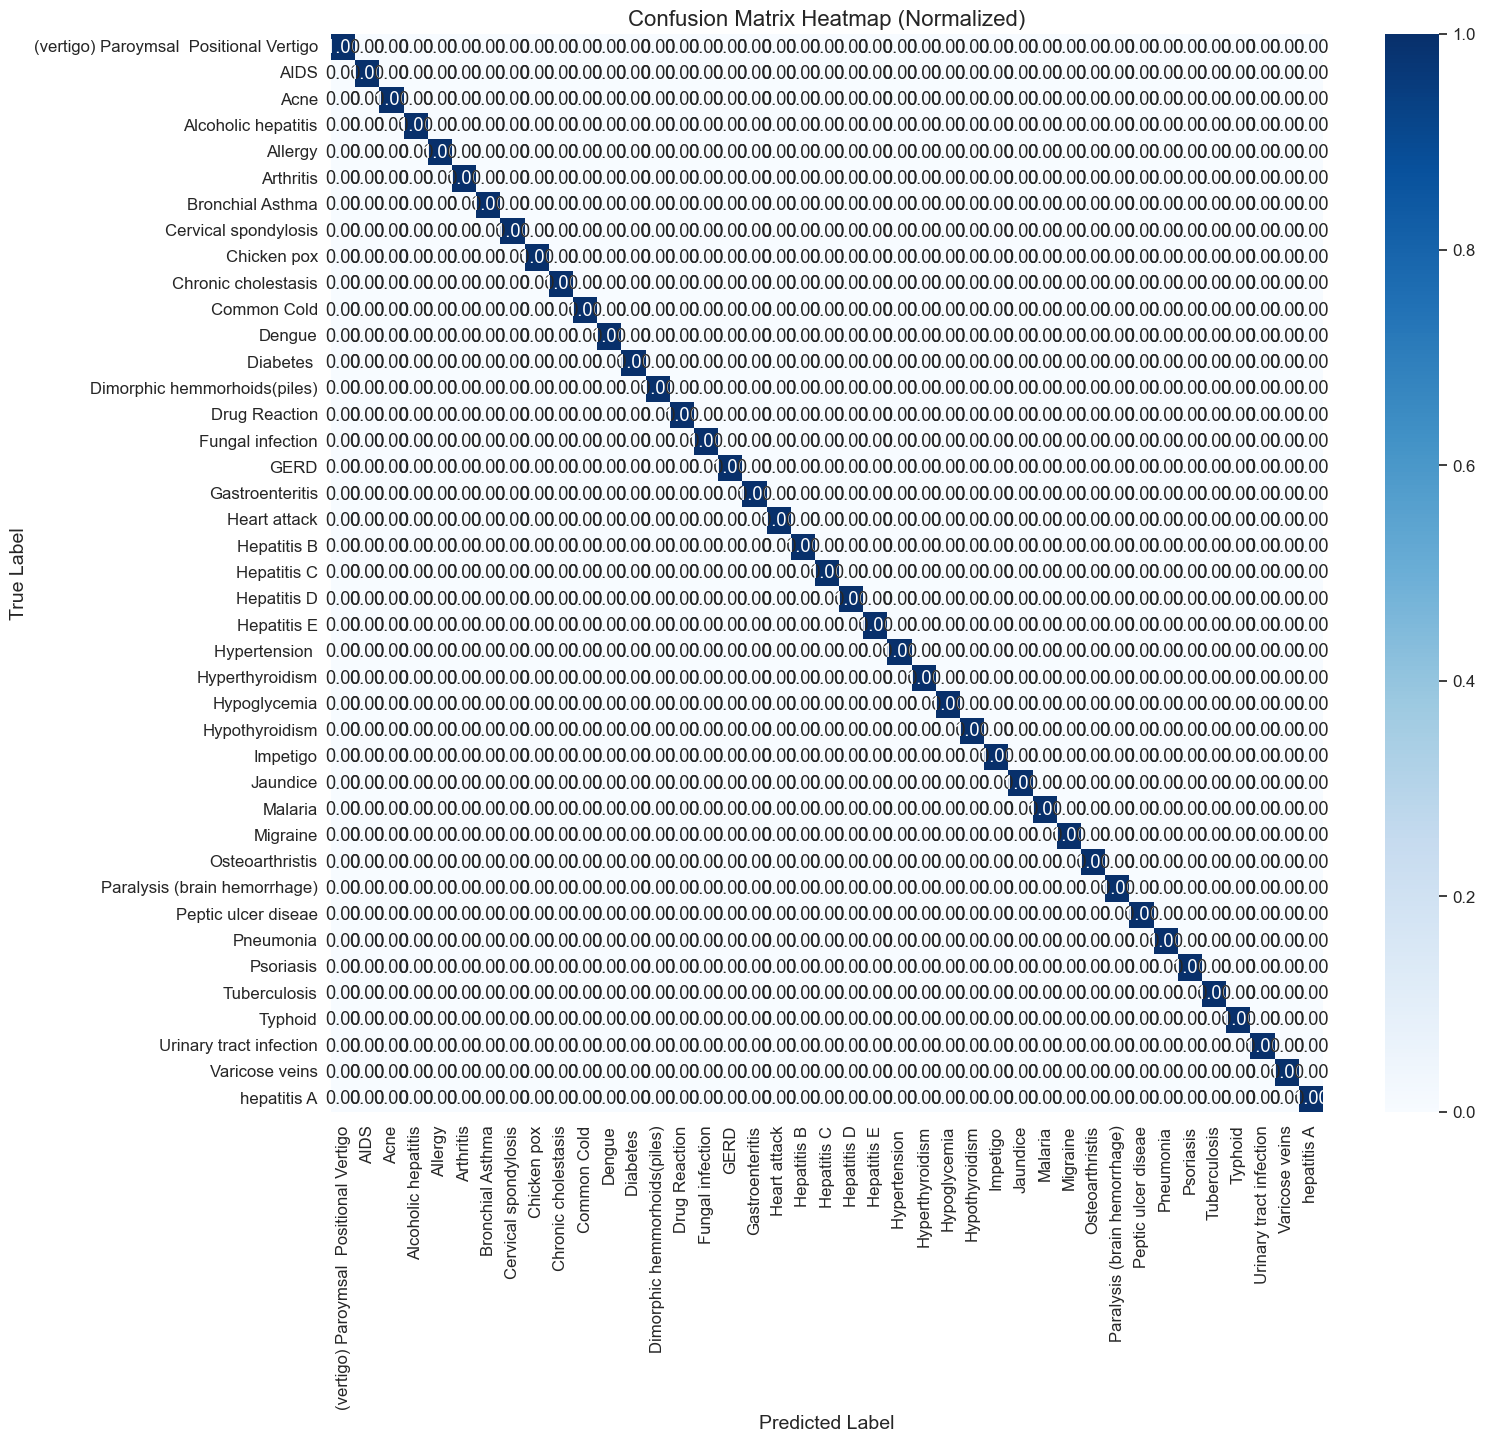

In [11]:
# 7. Confusion Matrix Heatmaps
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Raw Confusion Matrix Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap (Raw Counts)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix Heatmap (Normalized)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()


In [12]:
# 8. Save Decision Tree Model

import joblib

# Create a directory to save models 
MODEL_DIR = "saved_models"
import os
os.makedirs(MODEL_DIR, exist_ok=True)

# Save Decision Tree model
dt_model_path = os.path.join(MODEL_DIR, "decision_tree_model.pkl")
joblib.dump(dt_model, dt_model_path)
print(f"Decision Tree model saved at: {dt_model_path}")

# Save LabelEncoder
le_path = os.path.join(MODEL_DIR, "label_encoder.pkl")
joblib.dump(label_encoder, le_path)
print(f"Label Encoder saved at: {le_path}")


Decision Tree model saved at: saved_models\decision_tree_model.pkl
Label Encoder saved at: saved_models\label_encoder.pkl


In [13]:
# 9. Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # no depth limit
    random_state=SEED,
    n_jobs=-1              # use all cores
)

# Train model
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluation
acc_rf = accuracy_score(y_val, y_val_pred_rf)
print("Random Forest Accuracy on Validation Set:", round(acc_rf, 4))

print("\nClassification Report (Random Forest):")
print(classification_report(y_val, y_val_pred_rf, target_names=label_encoder.classes_))

# Confusion matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print("\nConfusion Matrix Shape (Random Forest):", cm_rf.shape)


Random Forest Accuracy on Validation Set: 1.0

Classification Report (Random Forest):
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                      

In [14]:
# 10. Save Random Forest Model
import joblib
import os

# Ensure model directory exists
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save Random Forest model
rf_model_path = os.path.join(MODEL_DIR, "random_forest_model.pkl")
joblib.dump(rf_model, rf_model_path)
print(f"Random Forest model saved at: {rf_model_path}")

# LabelEncoder already saved, no need to save again unless updating


Random Forest model saved at: saved_models\random_forest_model.pkl


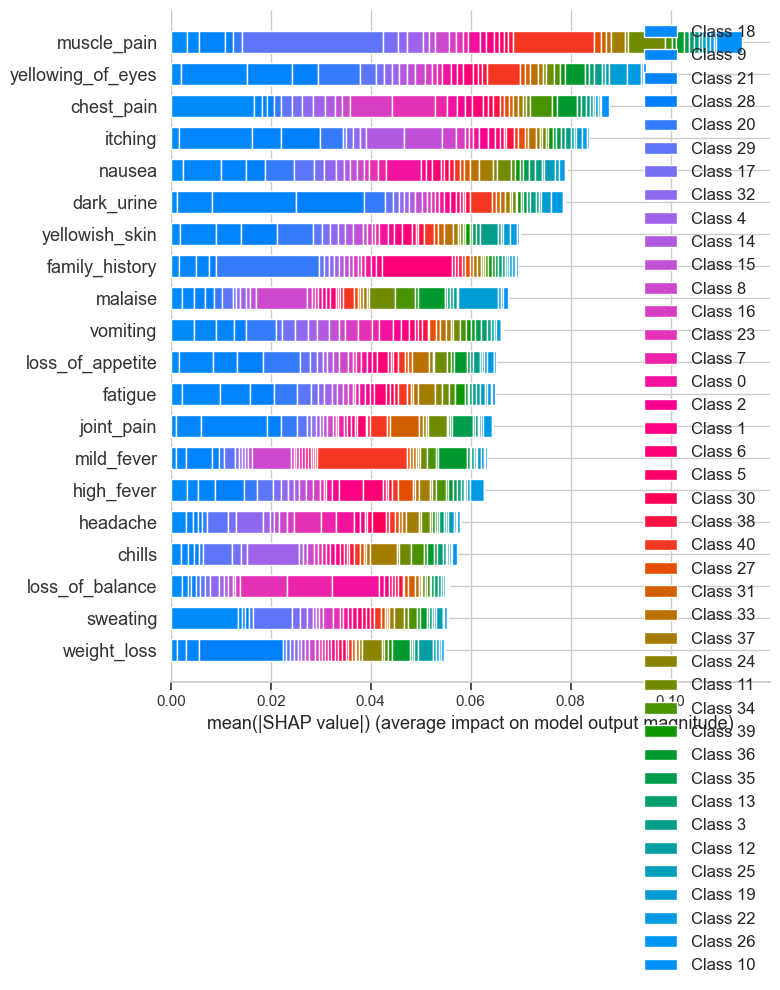

<Figure size 1200x800 with 0 Axes>

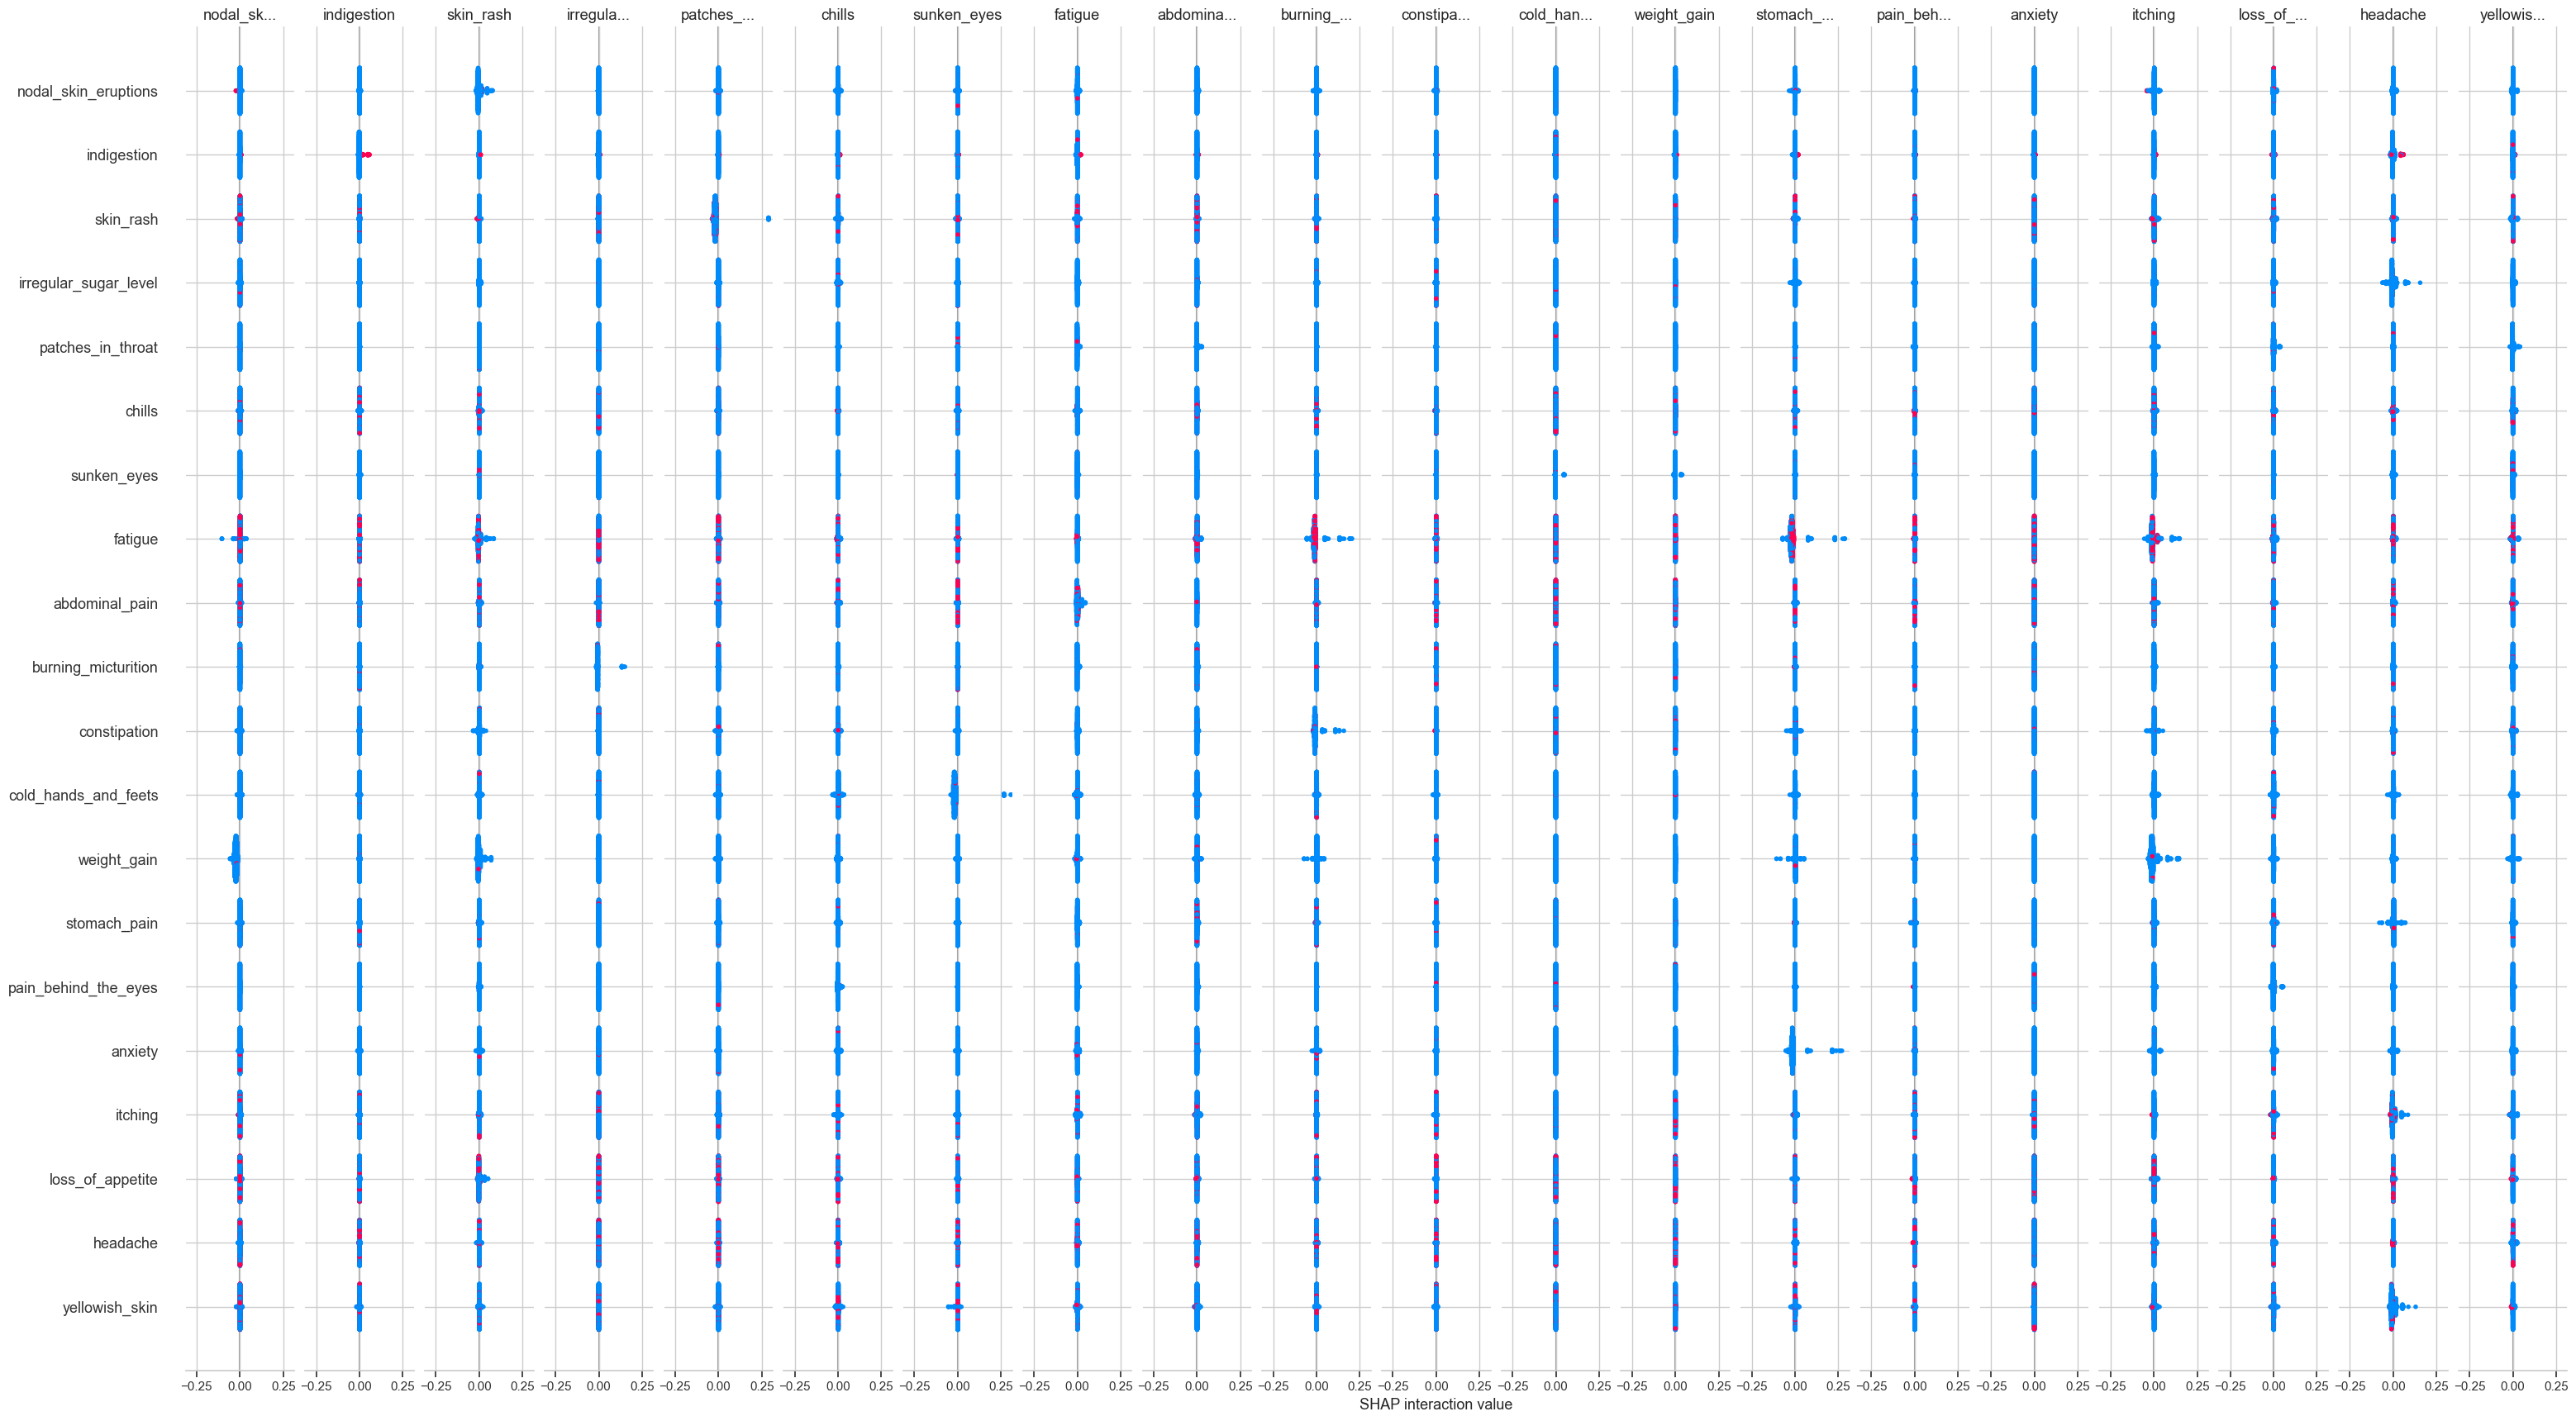

SHAP explainer saved at: saved_models\rf_shap_explainer.pkl


In [15]:
# 11. Feature Importance & SHAP Explanation
import shap

# Initialize SHAP explainer for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_val)

# 1. Global Feature Importance (mean absolute SHAP)
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=20)
plt.show()

# 2. SHAP Summary Plot (detailed)
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_val, max_display=20)
plt.show()

# Optional: Save explainer for later use in deployment
explainer_path = os.path.join(MODEL_DIR, "rf_shap_explainer.pkl")
joblib.dump(explainer, explainer_path)
print(f"SHAP explainer saved at: {explainer_path}")


In [16]:
import joblib
import os

# Absolute path to saved_models directory
MODEL_DIR = r"C:\Users\AKINMADE FARUQ\Downloads\PROJECT MATERIALS\My Projects\New upload\Disease Prediction\saved_models"

# Construct full file paths
rf_model_path = os.path.join(MODEL_DIR, "random_forest_model.pkl")
label_encoder_path = os.path.join(MODEL_DIR, "label_encoder.pkl")
explainer_path = os.path.join(MODEL_DIR, "rf_shap_explainer.pkl")

# Load models
rf_model = joblib.load(rf_model_path)
label_encoder = joblib.load(label_encoder_path)
explainer = joblib.load(explainer_path)

print("All models loaded successfully!")


All models loaded successfully!


In [18]:
import pandas as pd
import numpy as np
import os
import joblib

# Paths & Load Model
MODEL_DIR = r"C:\Users\AKINMADE FARUQ\Downloads\PROJECT MATERIALS\My Projects\New upload\Disease Prediction\saved_models"
rf_model_path = os.path.join(MODEL_DIR, "random_forest_model.pkl")
rf_model = joblib.load(rf_model_path)
symptom_features = rf_model.feature_names_in_

# Generate 100 Fake Patients
num_patients = 100
fake_data = np.random.randint(0, 2, size=(num_patients, len(symptom_features)))
fake_patients_df = pd.DataFrame(fake_data, columns=symptom_features)

# Save to CSV (no extra columns!)
output_csv_path = os.path.join(MODEL_DIR, "fake_patients.csv")
fake_patients_df.to_csv(output_csv_path, index=False)

print(f"Generated {num_patients} fake patients and saved to: {output_csv_path}")


Generated 100 fake patients and saved to: C:\Users\AKINMADE FARUQ\Downloads\PROJECT MATERIALS\My Projects\New upload\Disease Prediction\saved_models\fake_patients.csv


#  Smart Disease Prediction & Advisory System - Project Documentation
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade

## 1. Project Overview
This project presents a **machine learning-based disease prediction and advisory system** that predicts the most likely disease based on patient symptoms. It leverages **Random Forest Classifier** trained on a comprehensive dataset of 4920 patients covering 132 binary symptom features and 41 disease classes. The system also provides **health advisories** and visual explanations of predictions using **SHAP values**.

---

## 2. Objectives
- Predict diseases accurately using patient-reported symptoms.
- Provide top probable diseases with confidence probabilities.
- Offer actionable health advice for each predicted disease.
- Enable bulk prediction from CSV files with downloadable results.
- Visualize the impact of symptoms using SHAP feature importance plots.
- Implement a **user-friendly interface** using Streamlit for both single-patient and bulk predictions.

---

## 3. Dataset Information
- **Training set:** 4920 samples, 132 symptom features, 1 target (`prognosis`)
- **Test set:** 42 samples
- **Symptoms:** Binary features indicating presence (`1`) or absence (`0`) of a symptom
- **Target:** 41 unique disease classes
- **Class Distribution:** Balanced across diseases (each ~2.44%)

---

## 4. Methodology

### 4.1 Data Preprocessing
- Checked for missing values and handled them (train set had 1 missing column, test set was complete)
- Encoded categorical target variable using `LabelEncoder`
- Feature matrix separated from target vector
- Split training set into **train (80%)** and **validation (20%)** for model evaluation

### 4.2 Exploratory Data Analysis (EDA)
- Visualized **symptom co-occurrence heatmap**
- PCA and t-SNE plots for **class separability**
- Analyzed class distribution across training and validation sets

### 4.3 Model Development
- **Baseline:** Decision Tree Classifier (achieved 100% accuracy on validation set)
- **Final Model:** Random Forest Classifier
  - Hyperparameters tuned for optimal performance
  - Evaluated using accuracy, classification report, and confusion matrix
  - Saved trained model with `joblib` for deployment

### 4.4 Feature Importance & Explainability
- Integrated **SHAP (SHapley Additive exPlanations)** for visual explanation of feature impact
- Allows clinicians or users to understand which symptoms contributed most to predictions

---

## 5. Deployment
- Implemented using **Streamlit** for interactive use
- Features:
  - Single-patient prediction via checkboxes
  - Bulk CSV upload for multiple patients
  - Probability bar charts for top predicted diseases
  - SHAP-based feature importance plots
  - Health advisory output for each predicted disease
  - Downloadable CSV for bulk predictions

---

## 6. Usage Instructions
1. Run the Streamlit app:
   ```bash
   streamlit run "Disease Prediction + Advisory.py"
